In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.9.2'

In [ ]:
# Extraindo o a base de dados zipada (origem); (destino)
!unzip -u "/content/drive/MyDrive/Colab Notebooks/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks"

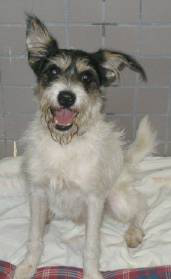

In [4]:
#Visualizando uma imagem da pasta dog de treinamento.
tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/test_set/test_set/dogs/dog.4028.jpg')

In [6]:
# realizando o redimensionamento e a normalização no conjunto de treinamento.
# rescale(normalizar padrao de cores); rotation (graus de rotação aleatorias) horizontal_flip(alterar orientação da foto) zoom (aplicação de zoom )
# target_size(tamanho que desejo migrar todas as fotos) batch_size(tamnaho do lote de dados) class_mode("categorical": 2D numpy array of one-hot encoded labels. Supports multi-label output.)
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/test_set/test_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 2023 images belonging to 2 classes.


Found 2023 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


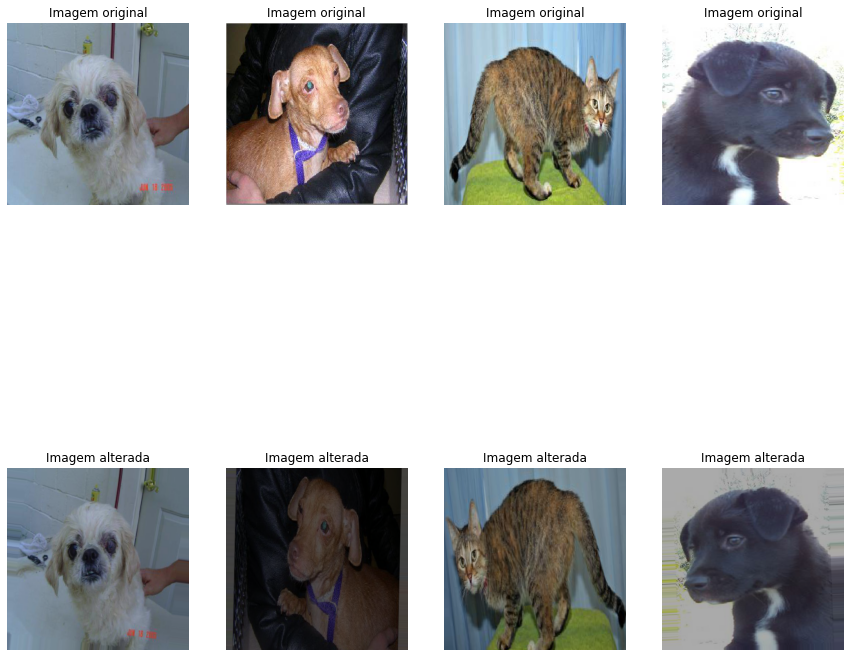

In [7]:
# Alterando as imagens.
datagen = ImageDataGenerator(
        rotation_range=7, # Rotação
        zoom_range=0.2, # aplicano 20% de zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brilho

# Imagem sem alteração.
datanorm = ImageDataGenerator()

# Conjunto com alterações
treino_alterado = datagen.flow_from_directory(
                  '/content/drive/MyDrive/Colab Notebooks/test_set/test_set',
                  target_size=(400, 400), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="binary", # classes
                  seed=2020 # para que os resultados sejam reproduzidos
                  )

# Conjunto sem sofrer alterações 
treino_normal = datanorm.flow_from_directory(
                  '/content/drive/MyDrive/Colab Notebooks/test_set/test_set',
                  target_size=(400, 400), 
                  color_mode="rgb", 
                  batch_size=1, 
                  class_mode="binary", 
                  seed=2020 
                  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

# Plotando 5 imagens
for i in range(4):

  # convertendo a imagem para inteiro
  image = next(treino_alterado)[0].astype('uint8')
  image2 = next(treino_normal)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

In [9]:
# realizando o redimensionamento e a normalização no conjunto de teste. 
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/test_set/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 2023 images belonging to 2 classes.


In [10]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [12]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [13]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

In [14]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [15]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [16]:
# Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [17]:
# visualizando as informações das camadas.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [18]:
# Adicionamos as 6 camadas finais ao modelo.
len(network.layers)

160

In [19]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [20]:
# Realizando o treimanto com 5 epocas.
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
16/16 [==============================] - 34s 2s/step - loss: 0.6226 - accuracy: 0.7889
Epoch 2/5
16/16 [==============================] - 34s 2s/step - loss: 0.1468 - accuracy: 0.9357
Epoch 3/5
16/16 [==============================] - 32s 2s/step - loss: 0.1027 - accuracy: 0.9619
Epoch 4/5
16/16 [==============================] - 34s 2s/step - loss: 0.0962 - accuracy: 0.9605
Epoch 5/5
16/16 [==============================] - 32s 2s/step - loss: 0.0864 - accuracy: 0.9674


In [21]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

2023/2023 [==============================] - 53s 26ms/step - loss: 0.0490 - accuracy: 0.9842


[0.04895636811852455, 0.9841818809509277]

In [23]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

2023/2023 [==============================] - 67s 33ms/step


array([[9.9995625e-01, 4.3790002e-05],
       [9.9089140e-01, 9.1086216e-03],
       [9.9999106e-01, 8.9393552e-06],
       ...,
       [4.1385636e-02, 9.5861435e-01],
       [7.1605049e-02, 9.2839491e-01],
       [1.7824088e-04, 9.9982184e-01]], dtype=float32)

In [24]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
# classificação real do conjunto de teste.
dataset_teste.classes[:10] # 10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
# usando a função de acurária do sklearn apenas para comparar se os resultados estão corretos.
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.9841819080573406

In [27]:
network.evaluate(dataset_teste)

2023/2023 [==============================] - 66s 32ms/step - loss: 0.0490 - accuracy: 0.9842


[0.04895636811852455, 0.9841818809509277]

In [28]:
dataset_treinamento.class_indices

{'cats': 0, 'dogs': 1}

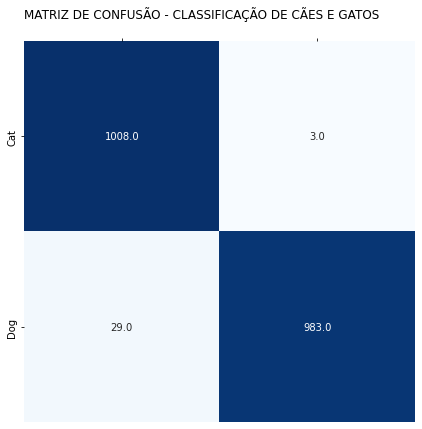

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = [' ', ' ']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc='left')
plt.show()

In [30]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1011
           1       1.00      0.97      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



In [31]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [32]:
# Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, '/content/drive/MyDrive/Colab Notebooks/weights.hdf5')

In [33]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "Conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "bn_Conv1", "trainable": false, "dtype": "float32", "axis

In [36]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/drive/MyDrive/Colab Notebooks/weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [37]:
# conferindo as informações das camadas.
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [58]:
# carregando uma imagem
imagem = cv2.imread('/content/drive/MyDrive/Colab Notebooks/test_set/test_set/dogs/dog.4025.jpg')

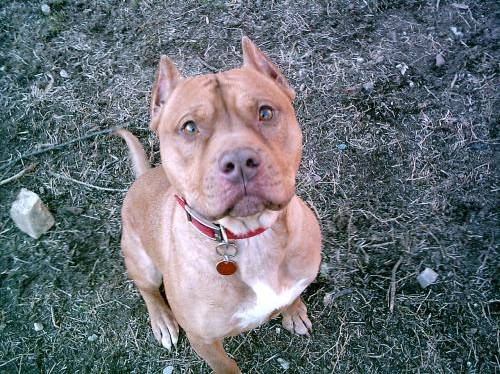

In [59]:
cv2_imshow(imagem)

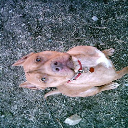

In [60]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem = cv2.resize(imagem, (128, 128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [61]:
# Normalizando a imagem.
imagem = imagem / 255
imagem

array([[[0.42745098, 0.37647059, 0.2745098 ],
        [0.25490196, 0.20784314, 0.10588235],
        [0.36470588, 0.30588235, 0.20392157],
        ...,
        [0.4       , 0.36862745, 0.2627451 ],
        [0.21176471, 0.2       , 0.11764706],
        [0.11372549, 0.10196078, 0.01960784]],

       [[0.31764706, 0.22745098, 0.1372549 ],
        [0.30588235, 0.23529412, 0.16470588],
        [0.36470588, 0.31372549, 0.24705882],
        ...,
        [0.2745098 , 0.2627451 , 0.17647059],
        [0.19215686, 0.18431373, 0.09411765],
        [0.1372549 , 0.1254902 , 0.03921569]],

       [[0.35686275, 0.28235294, 0.18823529],
        [0.32941176, 0.25882353, 0.19215686],
        [0.30980392, 0.24705882, 0.18431373],
        ...,
        [0.1372549 , 0.10980392, 0.02352941],
        [0.18039216, 0.18039216, 0.0627451 ],
        [0.24705882, 0.24705882, 0.1254902 ]],

       ...,

       [[0.26666667, 0.23921569, 0.12941176],
        [0.43529412, 0.39215686, 0.2745098 ],
        [0.54117647, 0

In [62]:
# Conferindo o formato
imagem.shape

(128, 128, 3)

In [63]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem = imagem.reshape(1,128,128,3)

In [64]:
# Realizando a previsão.
previsao = network_loaded(imagem)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00550629, 0.99449366]], dtype=float32)>

In [65]:
previsao = np.argmax(previsao)
previsao

1

In [66]:
dataset_teste.class_indices

{'cats': 0, 'dogs': 1}

In [67]:
if previsao == 0:
  print('O modelo identificou que o animal é um: Gato')
else:
  print('O modelo identificou que o animal é um: Cão')

O modelo identificou que o animal é um: Cão


### Creditos especiais a: https://github.com/Jcnok pela elaboração do modelo!